In [2]:
#reference: https://www.kaggle.com/benjibb/lstm-stock-prediction-20170507?scriptVersionId=1139231
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using TensorFlow backend.


In [180]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [ ]:
def hit_ratio(realvalue,predction):
    ratio = 0.0
    
    return ratio

In [4]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df.head()
# print set(df.symbol)

,symbol,open,low,high,volume,adj close
date,,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


In [40]:
from sklearn import preprocessing
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,0.137628,0.142787,0.132288,0.060533,0.145591
2010-01-05,0.144461,0.145746,0.133023,0.039480,0.148740
2010-01-06,0.143241,0.147472,0.134738,0.059818,0.147287
2010-01-07,0.134456,0.135142,0.124939,0.126378,0.135901
2010-01-08,0.131284,0.136375,0.121509,0.055702,0.135901


In [193]:
symbols = list(set(df.symbol))
stock_interest = 'AAPL'
len(symbols)
df3 = df[df.symbol == stock_interest]
df3.drop(['symbol'],1,inplace=True)
print df3.head()
df4 = df[df.symbol == 'GOOG']
df4.drop(['symbol'],1,inplace=True)
print df4.head()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


                 open        low       high       volume  adj close
date                                                               
2010-01-04  30.490000  30.340000  30.642857  123432400.0  30.572857
2010-01-05  30.657143  30.464285  30.798571  150476200.0  30.625713
2010-01-06  30.625713  30.107143  30.747143  138040000.0  30.138571
2010-01-07  30.250000  29.864286  30.285715  119282800.0  30.082857
2010-01-08  30.042856  29.865715  30.285715  111902700.0  30.282858
                  open         low        high      volume   adj close
date                                                                  
2010-01-04  312.304948  310.955001  313.580158   3927000.0  312.205308
2010-01-05  312.419511  309.610028  312.748278   6031900.0  310.830459
2010-01-06  311.761979  302.048370  311.761979   7987100.0  302.994813
2010-01-07  303.562685  295.218951  303.861575  12876600.0  295.941242
2010-01-08  294.895159  293.455551  300.499172   9483900.0  299.886470


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [196]:
symbols = list(set(df.symbol))
stock_interest = 'GOOG'
len(symbols)
df2 = df[df.symbol == stock_interest]
df2.drop(['symbol'],1,inplace=True)
print df2.head()
df = df[df.symbol == stock_interest]
df.drop(['symbol'],1,inplace=True)
print df.head()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


                  open         low        high      volume   adj close
date                                                                  
2010-01-04  312.304948  310.955001  313.580158   3927000.0  312.205308
2010-01-05  312.419511  309.610028  312.748278   6031900.0  310.830459
2010-01-06  311.761979  302.048370  311.761979   7987100.0  302.994813
2010-01-07  303.562685  295.218951  303.861575  12876600.0  295.941242
2010-01-08  294.895159  293.455551  300.499172   9483900.0  299.886470
                  open         low        high      volume   adj close
date                                                                  
2010-01-04  312.304948  310.955001  313.580158   3927000.0  312.205308
2010-01-05  312.419511  309.610028  312.748278   6031900.0  310.830459
2010-01-06  311.761979  302.048370  311.761979   7987100.0  302.994813
2010-01-07  303.562685  295.218951  303.861575  12876600.0  295.941242
2010-01-08  294.895159  293.455551  300.499172   9483900.0  299.886470


In [197]:
# df3 = normalize_data(df3)
# df3.head()
# df4 = normalize_data(df4)
# df4.head()

In [198]:
print df.shape
print df2.shape
df = normalize_data(df)
df.head()
df2 = normalize_data(df2)
df2.head()

(1762, 5)
(1762, 5)


,open,low,high,volume,adj close
date,,,,,
2010-01-04,0.157047,0.161167,0.156390,0.131722,0.159399
2010-01-05,0.157238,0.158884,0.154995,0.202469,0.157092
2010-01-06,0.156140,0.146049,0.153341,0.268184,0.143942
2010-01-07,0.142436,0.134457,0.140094,0.432522,0.132105
2010-01-08,0.127950,0.131464,0.134455,0.318492,0.138726


In [181]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [199]:
window = 22
X_train, y_train, X_test, y_test = load_data(df2, window)
print (X_train[0], y_train[0])

(array([[ 0.15704696,  0.16116746,  0.15638998,  0.1317225 ,  0.15939908],
       [ 0.15723843,  0.15888449,  0.15499506,  0.20246902,  0.15709185],
       [ 0.15613951,  0.14604929,  0.15334121,  0.26818406,  0.14394234],
       [ 0.14243617,  0.13445699,  0.14009362,  0.43252209,  0.13210528],
       [ 0.12795029,  0.13146379,  0.13445546,  0.3184921 ,  0.13872603],
       [ 0.13832355,  0.1356323 ,  0.13546617,  0.48640628,  0.1379653 ],
       [ 0.13265404,  0.13052526,  0.13020388,  0.3271972 ,  0.12907917],
       [ 0.11503787,  0.1186032 ,  0.12203482,  0.43807453,  0.12624527],
       [ 0.12120685,  0.12613696,  0.12689613,  0.2858228 ,  0.12855249],
       [ 0.12906589,  0.12210374,  0.12636158,  0.36641044,  0.12031836],
       [ 0.11895908,  0.12062405,  0.12373877,  0.29099208,  0.12668832],
       [ 0.12293853,  0.11977851,  0.12003013,  0.21906583,  0.12066114],
       [ 0.12082392,  0.1172081 ,  0.12073176,  0.42532947,  0.1228095 ],
       [ 0.10505596,  0.0855935 ,  0.

In [200]:
model = build_model([5,window,1])
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

('Compilation Time : ', 0.0449678897857666)
Train on 1408 samples, validate on 157 samples
Epoch 1/90
1408/1408 [==============================] - 8s 6ms/step - loss: 0.1278 - acc: 7.1023e-04 - val_loss: 0.4896 - val_acc: 0.0000e+00
Epoch 2/90
1408/1408 [==============================] - 5s 4ms/step - loss: 0.0560 - acc: 7.1023e-04 - val_loss: 0.0409 - val_acc: 0.0000e+00
Epoch 3/90
1408/1408 [==============================] - 5s 4ms/step - loss: 0.0338 - acc: 7.1023e-04 - val_loss: 0.1247 - val_acc: 0.0000e+00
Epoch 4/90
1408/1408 [==============================] - 6s 4ms/step - loss: 0.0141 - acc: 7.1023e-04 - val_loss: 0.1891 - val_acc: 0.0000e+00
Epoch 5/90
1408/1408 [==============================] - 6s 4ms/step - loss: 0.0162 - acc: 7.1023e-04 - val_loss: 0.0959 - val_acc: 0.0000e+00
Epoch 6/90
1408/1408 [==============================] - 6s 4ms/step - loss: 0.0056 - acc: 7.1023e-04 - val_loss: 0.0359 - val_acc: 0.0000e+00
Epoch 7/90
1408/1408 [==============================] - 6

In [201]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
print (p.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    # print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
    # Last day prediction
    # print(p[-1]) 

(174, 1)


In [202]:
df = pd.read_csv("data/prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df = df[df.symbol == stock_interest]
df.drop(['symbol'],1,inplace=True)

# Bug fixed at here, please update the denormalize function to this one
def denormalize(df, normalized_value): 
    df = df['adj close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, p)
newy_test = denormalize(df, y_test)

In [203]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)



Train Score: 0.00120 MSE (0.03 RMSE)
Test Score: 0.01128 MSE (0.11 RMSE)


(0.0012012484083219934, 0.011281966756301364)

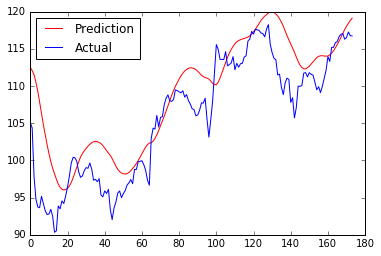

In [189]:
import matplotlib.pyplot as plt2

plt2.plot(newp,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

In [188]:
print stock_interest

AAPL


In [52]:
import statsmodels.api as sm
import statsmodels.api as sm
res = sm.tsa.arma_order_select_ic(y_train, ic=['aic', 'bic'], trend='nc')
print res.aic_min_order
print res.bic_min_order

/Library/Python/2.7/site-packages/statsmodels-0.6.1-py2.7-macosx-10.10-intel.egg/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Python/2.7/site-packages/statsmodels-0.6.1-py2.7-macosx-10.10-intel.egg/statsmodels/tsa/tsatools.py:492: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Library/Python/2.7/site-packages/statsmodels-0.6.1-py2.7-macosx-10.10-intel.egg/statsmodels/tsa/tsatools.py:493: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Library/Python/2.7/site-packages/statsmodels-0.6.1-py2.7-macosx-10.10-intel.egg/statsmodels/tsa/tsatools.py:493: RuntimeWarning: invalid value encountered in divide
  (1+np.exp(-params))).copy()
/Library/Python/2.7/site-packages/statsmodels-0.6.1-py2.7-macosx-10.10-intel.egg/statsmodels/tsa/tsatools.py:494: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(

(1, 0)
(1, 0)


In [117]:
print y_train.shape
print y_test.shape
y_all = list(y_train).append(list(y_test))

(1565,)
(174,)


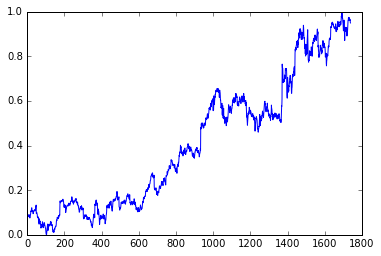

In [132]:
# print list(y_train)
y_all = np.zeros(1565+174)
y_all[:1565] = y_train
y_all[1565:] = y_test
plt2.plot(y_all)
plt2.show()

/Library/Python/2.7/site-packages/statsmodels-0.6.1-py2.7-macosx-10.10-intel.egg/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


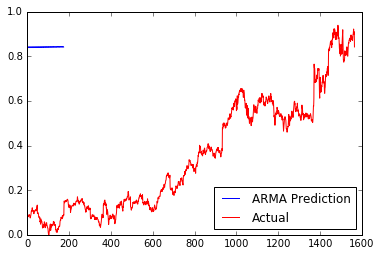

In [150]:
from statsmodels.tsa.arima_model import ARMA
my_order = res.aic_min_order
arma_model = ARMA(y_train,(3,2),freq = 'Q').fit()
arma_y = arma_model.predict(start = 1565,end = 1565+174,dynamic=True)

# arma_y = arma_model.predict(start = 4,end = 1700)
plt2.figure(2)
plt2.plot(arma_y,color='blue', label='ARMA Prediction')
plt2.plot(y_train,color='red', label='Actual')
plt2.legend(loc='best')
plt2.show()

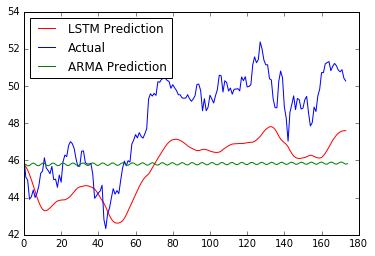

In [151]:
# arma_model.fit()
# arma_y = arma_model.predict(start = 1,end = 1700,exog = y_train)
arma_pred = denormalize(df, arma_y)
# import matplotlib.pyplot as plt2

plt2.plot(newp,color='red', label='LSTM Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.plot(arma_pred,color='green', label='ARMA Prediction')
plt2.legend(loc='best')
plt2.show()

174
175
[ 0.84139051  0.8410993   0.84080829  0.84051748  0.84022687  0.83993647
  0.83964626  0.83935626  0.83906646  0.83877686]
[ 0.87076446  0.88249493  0.8969774   0.89946115  0.90919449  0.92196531
  0.90068618  0.89857168  0.90942946]
[ 0.07582908  0.07959922  0.08142161  0.0839044   0.08224082  0.08387095
  0.08112903  0.08796707  0.08538401  0.08957211]
1565


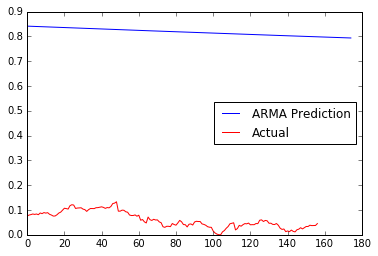

In [96]:
print len(y_test)
print len(arma_y)
print arma_y[:10]
print y_train[-10:-1]
print y_train[:10]
print len(y_train)
plt2.figure(2)
plt2.plot(arma_y,color='blue', label='ARMA Prediction')
plt2.plot(y_train[:157],color='red', label='Actual')
plt2.legend(loc='best')
plt2.show()
                